In [1]:
import pandas as  pd
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from sklearn.ensemble import RandomForestClassifier
from sktree import ObliqueRandomForestClassifier, PatchObliqueRandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

In [2]:
df = pd.read_excel('/cis/home/jdey4/data_MRI/subjects_age_sex_data_MRI.xlsx')
df.head()

,ID,Age,Sex,Dataset,Dataset-ID
0,sub-ABIDE1050339,18.0000,MALE,ABIDE,50339
1,sub-ABIDE1050701,18.0000,MALE,ABIDE,50701
2,sub-ABIDE1050445,18.1383,MALE,ABIDE,50445
3,sub-ABIDE1050459,18.1547,MALE,ABIDE,50459
4,sub-ABIDE1050341,18.2000,FEMALE,ABIDE,50341


In [3]:
df_quality = pd.read_csv('/cis/home/jdey4/data_MRI/QC_catreport.csv')
df_quality.head()

,sub,Weighted average (IQR),Warning
0,sub-A00008326,83.86,0
1,sub-A00008399,83.3,0
2,sub-A00010893,78.3,0
3,sub-A00013809,79.36,0
4,sub-A00018030,84.05,0


### Load the mask

In [4]:
mask = nb.load('/cis/home/jdey4/data_MRI/template_cat12/brainmask.nii').get_fdata()

Text(0.5, 1.0, 'Mask (Traverse)')

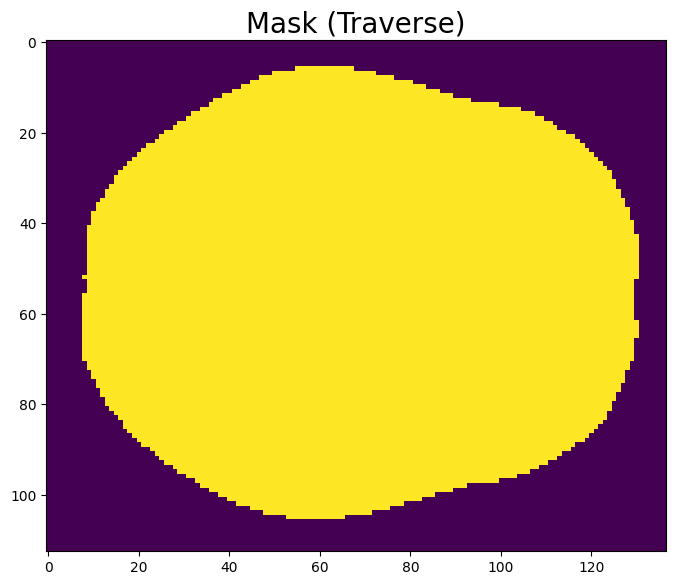

In [5]:
slice=50
sliced_img = mask[:,:,slice]

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.imshow(sliced_img)

ax.set_title('Mask (Traverse)', fontsize=20)

In [6]:
idx = np.where(mask.reshape(-1)>0)[0]

### Load data and build (feature, label)

In [7]:
path = '/cis/home/jdey4/data_MRI/'
subjects = os.listdir(path)
X = []
y = []
file_no = 0
IDs = set(df['ID'])
quality_ID = set(df_quality['sub'])
for subject in tqdm(subjects):
    if subject in IDs and subject in quality_ID:
        #print(df[df['ID']==subject]['Sex'])
        IQR = list(df_quality[df_quality['sub']==subject]['Weighted average (IQR)'])[0]
        
        if IQR is np.nan:
            continue
            
        if IQR[-1] == '%':
            continue
        
        if float(IQR) < 60:
            continue
            
        gender = list(df[df['ID']==subject]['Sex'])
        sex = int(gender[0]=='FEMALE')
        
        
        current_file = os.path.join(path, subject)
        tmp = []
        save = True
        for file in glob.glob(current_file+'/mri/*'):
            try:
                img = nb.load(file).get_fdata()
                file_no += 1
                #print(img.shape)
                tmp.append(img.reshape(-1)[idx])
            except:
                save = False
                print(file,' corrupted')

        '''if len(tmp)<2:
            print(subject, ' has less files')'''
            
        if save and len(tmp)==2:
            X.append(np.array(tmp).reshape(1,-1))
            y.append(sex)
    
X = np.concatenate(X,axis=0)

100%|████████████████████████████████████████████████████████████████████| 14471/14471 [14:57<00:00, 16.12it/s]


In [8]:
X.shape

(2206, 1298282)

In [9]:
np.mean(y)

0.5485040797824116

In [32]:
file_no

13792

### Find the feature importance

In [81]:
reps = 100
sample_size_ratio = .8
feature_map_diff = np.zeros(X.shape[1], dtype=float)
accuracy = 0

for ii in tqdm(range(reps)):
    x_train, x_test, y_train, y_test = train_test_split(
                    X, y, train_size=sample_size_ratio,random_state=ii, stratify=y)
    total_sample = len(x_train)
    y_random = y_train.copy()
    random.shuffle(y_random)
    
    clf_random = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    
    clf_random.fit(x_train,y_random)
    clf.fit(x_train,y_train)

    predicted_label = clf.predict(x_test)
    accuracy += np.mean(predicted_label==y_test)
    
    random_importance_map = clf_random.feature_importances_
    importance_map = clf.feature_importances_
    diff = importance_map - random_importance_map
    feature_idx = np.where(diff > 0)[0]
    map_diff = np.zeros(X.shape[1], dtype=float)
    map_diff[feature_idx] = 1
    
    feature_map_diff += map_diff

feature_map_diff /= reps
accuracy /= reps

print('Accuracy is ',accuracy)

100%|████████████████████████████████████████████████████████████████████████| 100/100 [45:21<00:00, 27.22s/it]

Accuracy is  0.8288009049773757


In [82]:
demo_filepath_whitematter = '/cis/home/jdey4/data_MRI/sub-A00008326/mri/mwp2sub-A00008326_T1w.nii'
demo_filepath_graymatter = '/cis/home/jdey4/data_MRI/sub-A00008326/mri/mwp1sub-A00008326_T1w.nii'

img_whitematter = nb.load(demo_filepath_whitematter).get_fdata()
img_graymatter = nb.load(demo_filepath_graymatter).get_fdata()

In [83]:
importance_map[np.where(importance_map>0)[0]]

array([2.07767978e-05, 7.11412948e-05, 9.61403667e-05, ...,
       2.27352584e-05, 2.02377941e-05, 6.23278013e-05])

In [84]:
brain_img = 0*np.ones((113*137*113), dtype=float)
brain_img[idx] = feature_map_diff[:len(idx)]
brain_img = brain_img.reshape(113,137,113)

Text(0.5, 1.0, 'White matter (Traverse)')

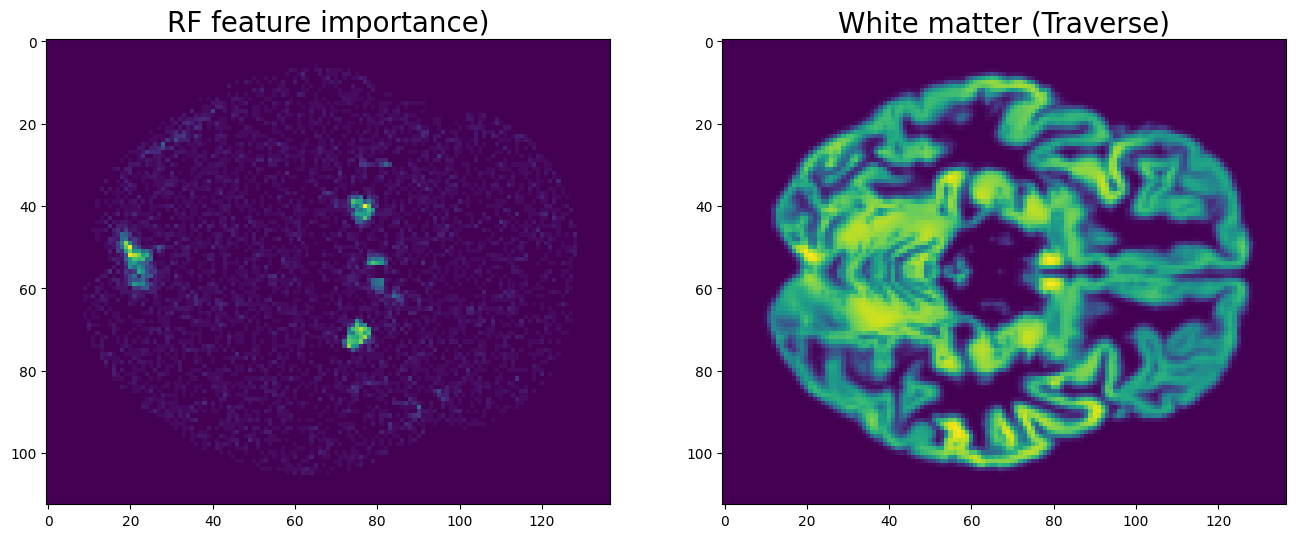

In [86]:
slice = 39

sliced_img_whitematter = img_whitematter[:,:,slice]
sliced_img_graymatter = img_graymatter[:,:,slice]

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(brain_img[:,:,slice])
ax[1].imshow(sliced_img_graymatter)

ax[0].set_title('RF feature importance)', fontsize=20)
ax[1].set_title('White matter (Traverse)', fontsize=20)

### Todos

1. do rank test
2. report accuracy
3. do morf

In [89]:
img_white = nb.load(demo_filepath_whitematter)
img = nb.Nifti1Image(brain_img, header = img_white.header, affine = img_white.affine)

In [90]:
nb.save(img, 'feature_imp.nii') 